## Install and Import Libraries

In [1]:
# Only for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Use CUDA 12.4 with these torch versions!!!**

- [Download CUDA 12.4](https://developer.nvidia.com/cuda-12-4-0-download-archive?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local)
- [Download cuDNN 8.9.7](https://developer.nvidia.com/rdp/cudnn-archive)

In [ ]:
# Install required packagess

%pip install ultralytics
%pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import Essential Libraries
from ultralytics import YOLO
import torch

In [3]:
# Check if GPU is available
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce GTX 1660 SUPER


## Traffic Lights Detection (Custom Dataset)

### Train on Large model

In [ ]:
# Load Model
model = YOLO("/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11l.pt")

In [ ]:
# Fine-Tune Model
train_results = model.train(
    data="/content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,
)

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11l.pt, data=/content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/train/labels.cache... 642 images, 31 backgrounds, 0 corrupt: 100%|██████████| 642/642 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/valid/labels.cache... 45 images, 4 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.5G      1.657      2.414      1.746         17        640: 100%|██████████| 41/41 [00:31<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         45         66      0.119      0.287     0.0612     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      12.6G      1.797      1.896      1.826          3        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         45         66          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.7G      1.829      1.855      1.868          5        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         45         66      0.493     0.0098    0.00577    0.00346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.8G      1.851      1.835      1.873          5        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         45         66      0.933      0.208      0.328      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.9G      1.789      1.715      1.815          7        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         45         66      0.309      0.592      0.434      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.9G      1.711      1.637      1.742          4        640: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         45         66      0.218      0.406      0.276      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.9G      1.744      1.682      1.779          3        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         45         66      0.502      0.737      0.774      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.9G      1.654      1.578      1.694          2        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         45         66      0.452      0.433       0.46      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.9G      1.639      1.587      1.721         16        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         45         66       0.65      0.552      0.584      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.9G      1.608      1.541      1.686         11        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         45         66      0.578      0.582      0.593      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        13G      1.571      1.479      1.653          4        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         45         66      0.814      0.714       0.84      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        13G      1.556      1.403      1.642          5        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         45         66      0.857      0.695      0.817      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50        13G      1.573      1.393      1.668          8        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         45         66      0.807      0.476      0.706      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        13G       1.52      1.387      1.623         10        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         45         66      0.841      0.722      0.853       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        13G      1.501      1.376      1.585          7        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         66      0.477      0.818      0.769      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        13G      1.496      1.368        1.6          8        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         45         66      0.757      0.655      0.794      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50        13G      1.465      1.359      1.573          8        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         45         66      0.788      0.777      0.863       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50        13G      1.501      1.354      1.613          2        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         45         66      0.728       0.78      0.879      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50        13G      1.444      1.291      1.579         12        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         45         66      0.858       0.71       0.86      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        13G      1.461      1.315      1.587          3        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         45         66      0.913      0.789       0.88      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        13G       1.43      1.266       1.58          9        640: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         66      0.769       0.79      0.922       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        13G      1.465      1.258      1.575          7        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         45         66      0.781      0.797       0.86       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        13G      1.429      1.216      1.578          3        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         45         66      0.746      0.763      0.829      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        13G      1.402      1.186      1.529          5        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         45         66      0.842      0.716      0.853      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        13G      1.377       1.23      1.524          7        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         45         66      0.705      0.746      0.885      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        13G      1.379      1.168      1.514          6        640: 100%|██████████| 41/41 [00:28<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         45         66      0.732      0.801      0.797      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50        13G      1.358      1.121      1.518          3        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         45         66      0.798      0.811      0.875      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        13G      1.382      1.113      1.507          8        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         45         66      0.921      0.849      0.928      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        13G      1.345      1.086      1.518          8        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         45         66      0.827       0.83      0.889      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        13G      1.322      1.086      1.473          4        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         45         66      0.831      0.846       0.91      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        13G      1.362      1.104      1.498         18        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         45         66      0.777      0.813      0.895      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50        13G      1.314      1.092      1.476          9        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         45         66      0.872      0.818      0.898      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        13G      1.347      1.076      1.529         10        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         45         66      0.843      0.798       0.89      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        13G      1.278      1.016      1.446         10        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         66      0.761      0.815      0.865       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        13G      1.301      1.007      1.455          9        640: 100%|██████████| 41/41 [00:28<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         45         66      0.804      0.847      0.881      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50        13G      1.277      1.007      1.431          7        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         45         66      0.807      0.852      0.898      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50        13G      1.293      1.005      1.464          3        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         45         66      0.855      0.757      0.895      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        13G      1.291     0.9469      1.487          5        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         66      0.786      0.795      0.863      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50        13G       1.24     0.9762      1.436          9        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         45         66      0.892        0.9      0.945      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50        13G      1.274     0.9428      1.444          3        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         45         66       0.86      0.739      0.839      0.423


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50        13G      1.257     0.8944      1.512          9        640: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         45         66      0.849       0.85      0.914      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        13G      1.231     0.8652      1.478          4        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         45         66      0.871      0.852      0.913      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        13G      1.195     0.8069      1.475          1        640: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         45         66      0.864       0.81      0.894      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        13G      1.201     0.7971      1.461          8        640: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         45         66      0.824       0.84      0.863      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50        13G      1.186     0.8338      1.434          2        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         45         66      0.894      0.842      0.906      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50        13G       1.18     0.7799      1.439          2        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         45         66      0.838      0.878      0.905      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50        13G      1.183     0.7559      1.433          3        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         45         66      0.871      0.841      0.912      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        13G      1.154     0.7626      1.403          4        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         45         66      0.858      0.754      0.876      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50        13G       1.15       0.75      1.404          5        640: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         45         66      0.815      0.852      0.881      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50        13G      1.125     0.7114      1.403          4        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         45         66      0.819      0.856       0.89      0.473



50 epochs completed in 0.443 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


                   all         45         66      0.872      0.841      0.913      0.479
          green-lights         22         24      0.856      0.875      0.942      0.436
            red-lights         28         34      0.806      0.647      0.802      0.418
         yellow-lights          7          8      0.953          1      0.995      0.582
Speed: 0.2ms preprocess, 17.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Evaluate model performance on the validation set
model = YOLO("/content/drive/MyDrive/AutoDrive/trained-models/yolo_large_trafficlights.pt")
metrics = model.val()

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/valid/labels.cache... 45 images, 4 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


                   all         45         66      0.814      0.874       0.91      0.475
          green-lights         22         24      0.794      0.917      0.934      0.424
            red-lights         28         34      0.717      0.706      0.803      0.419
         yellow-lights          7          8       0.93          1      0.995      0.582
Speed: 7.1ms preprocess, 32.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val



image 1/1 /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/test/images/images_jpeg.rf.f93f1d5e624f19c28d4ed1855fbbb545.jpg: 640x640 1 green-lights, 47.5ms
Speed: 2.4ms preprocess, 47.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


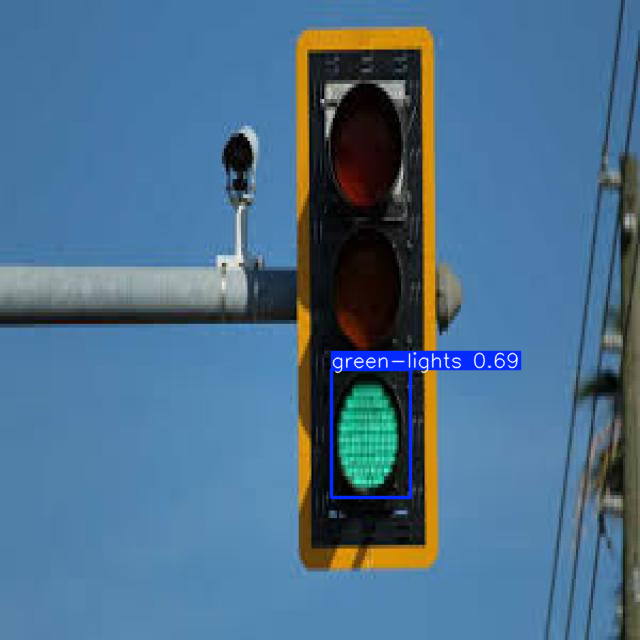

In [ ]:
# Perform object detection on an image
results = model("/content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/test/images/images_jpeg.rf.f93f1d5e624f19c28d4ed1855fbbb545.jpg")
results[0].show()

### Train on Nano model

In [ ]:
# Load Model
model = YOLO("/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11n.pt")

In [ ]:
# Fine-Tune Model
train_results = model.train(
    data="/content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/data.yaml",
    epochs=100,
    imgsz=640,
    batch=64,
    device=0,
)

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11n.pt, data=/content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/data.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

train: Scanning /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/train/labels.cache... 642 images, 31 backgrounds, 0 corrupt: 100%|██████████| 642/642 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/valid/labels.cache... 45 images, 4 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.02G      1.527      3.816      1.592         10        640: 100%|██████████| 11/11 [00:13<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         45         66    0.00292      0.649       0.18      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.02G      1.448      3.144      1.362          3        640: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         45         66    0.00486      0.824       0.44      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.02G      1.429      2.427      1.358          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         45         66    0.00468      0.868      0.553      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.02G      1.436      2.071      1.428          6        640: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         45         66      0.911      0.338      0.568      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.02G      1.461      1.963      1.406          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         45         66          1      0.203      0.673      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.02G      1.472       1.89      1.406          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         45         66      0.917      0.162      0.417      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.02G      1.443      1.746      1.442          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         45         66      0.648      0.381      0.338      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.02G      1.483      1.666      1.481          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         45         66      0.701      0.363       0.53       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.02G      1.508      1.691      1.443          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         45         66      0.585      0.587      0.542      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.02G      1.453      1.551      1.418         11        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         45         66      0.661      0.267      0.407      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.02G      1.507      1.653      1.454          3        640: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         45         66       0.39      0.634      0.418      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.02G      1.462      1.517      1.469          3        640: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         45         66      0.882      0.602      0.697      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.02G      1.489      1.447      1.458          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         45         66      0.472       0.58       0.55      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.02G      1.445      1.369      1.427         13        640: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         45         66      0.805      0.502      0.609       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.02G      1.431      1.326      1.428          8        640: 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         45         66      0.546      0.487      0.552       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.02G      1.463      1.258      1.451          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         45         66      0.683      0.672      0.743      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.02G      1.396       1.21      1.406         20        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         45         66       0.76      0.736      0.784      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.02G      1.583      1.375      1.615          2        640: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         45         66      0.937      0.686      0.783      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.02G      1.452      1.204      1.435          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         45         66      0.826      0.694      0.808      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.02G      1.338      1.139      1.388          3        640: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         45         66      0.922      0.799      0.879      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.02G      1.373      1.108      1.404          9        640: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         45         66      0.736      0.829      0.851      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.02G      1.368      1.097      1.404          8        640: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         45         66      0.647      0.609      0.622      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.02G      1.351      1.072      1.386          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         45         66      0.748       0.71      0.741      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.02G      1.376       1.04      1.428          4        640: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         45         66      0.864      0.705      0.809      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.02G      1.296      1.002      1.332          6        640: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         45         66      0.925      0.824      0.882      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.02G      1.341     0.9718      1.356         11        640: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         45         66      0.755      0.726      0.773      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.02G      1.307     0.9952      1.323          8        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         45         66      0.814      0.781      0.821      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.02G        1.3     0.9548      1.298         25        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         45         66      0.852      0.692      0.802      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.02G      1.336     0.9701      1.373          8        640: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         45         66      0.894      0.783      0.868      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.02G      1.353      0.993      1.349          9        640: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         45         66      0.893      0.715      0.801      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.02G      1.281     0.9116      1.296         18        640: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         45         66      0.819      0.766      0.789      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.02G      1.324     0.8589      1.358          8        640: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         45         66      0.807      0.806      0.812      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.02G      1.309     0.8908       1.37          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         45         66      0.891      0.743      0.827      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.02G       1.24     0.8409      1.283         11        640: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         45         66       0.76      0.846      0.871      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.02G       1.24     0.8421      1.288          7        640: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         45         66      0.914      0.878       0.91      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.02G      1.335     0.8408      1.344          8        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         45         66      0.707      0.775      0.766      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.02G      1.277     0.8778      1.278          6        640: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         45         66      0.819      0.823      0.881      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.02G      1.278     0.8789      1.337          3        640: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         45         66      0.812      0.844      0.912       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.02G      1.223      0.832      1.282          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         45         66       0.92      0.844      0.933      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.02G      1.359       0.88      1.395          3        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         45         66      0.953      0.745      0.862       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.02G      1.246     0.8011      1.292         12        640: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         45         66      0.907      0.801      0.884      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.02G      1.242      0.827       1.38          3        640: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         45         66       0.85      0.789      0.819      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.02G      1.218     0.8018      1.259          8        640: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         45         66      0.753      0.777      0.809      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.02G      1.219     0.7496      1.313          8        640: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         45         66      0.953      0.896      0.959      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.02G      1.145     0.7288      1.215         12        640: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         45         66      0.911       0.89      0.941      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.02G      1.156     0.7413      1.222          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         45         66      0.894      0.885      0.924      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.02G      1.118      0.715      1.227         11        640: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         45         66      0.903      0.896      0.926      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.02G        1.2     0.7299      1.277          8        640: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         45         66      0.903      0.893      0.919       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.02G       1.16     0.7074       1.23         11        640: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         45         66      0.839      0.874      0.888      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.02G      1.092     0.6943      1.199         17        640: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         45         66      0.904      0.881      0.921       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.02G      1.077     0.6907      1.195          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         45         66      0.932       0.87      0.946      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.02G      1.055     0.7029      1.189          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         45         66      0.854       0.89      0.925      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.02G      1.094     0.6854      1.201          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         45         66      0.877      0.872      0.941      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.02G      1.116      0.667      1.202          6        640: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         45         66       0.94      0.885      0.953      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.02G      1.125     0.7184      1.241          4        640: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         45         66      0.939      0.919      0.943      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.02G      1.097     0.6443      1.201          8        640: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         45         66      0.911      0.784      0.847      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.02G      1.099     0.6686      1.235          3        640: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         45         66      0.797       0.84      0.842      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.02G      1.005     0.6267      1.166          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         45         66       0.89      0.893      0.914       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.02G      1.054     0.6768      1.195          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         45         66       0.93      0.767      0.882      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.02G      1.108     0.6696      1.221          7        640: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         45         66      0.956      0.892       0.91      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.02G      1.042     0.6594       1.16          8        640: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         45         66      0.917      0.888      0.945      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.02G      1.093     0.6623      1.227          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         45         66      0.947      0.855      0.911      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.02G       1.02     0.6037      1.138         19        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         45         66       0.93      0.914      0.937      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.02G      1.051     0.6168      1.163          4        640: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         45         66      0.927      0.854      0.939      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.02G      1.003     0.6294      1.139          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         45         66      0.877      0.877      0.922      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.02G      1.063     0.6775      1.214          3        640: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         45         66      0.891      0.814      0.918      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.02G      1.129     0.7655       1.27          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         45         66      0.907      0.931      0.955       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.02G      1.033     0.6553      1.143          1        640: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         45         66      0.972      0.907      0.948      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.02G       1.05      0.588      1.168         10        640: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         45         66      0.909      0.882      0.888      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.02G      1.014     0.6015      1.156          6        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         45         66      0.929        0.9      0.945      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.02G      1.015     0.5566      1.143          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         45         66      0.921      0.887       0.93      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.02G      1.075     0.6404      1.147          9        640: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         45         66      0.942       0.85      0.919       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.02G     0.9307     0.6616      1.105          3        640: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         45         66      0.971      0.901      0.948      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.02G      0.934     0.5701      1.114          3        640: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         45         66      0.933      0.897      0.918      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.02G     0.9484     0.5679      1.117          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         45         66      0.912       0.86      0.899      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.02G     0.9169     0.5431      1.083         11        640: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         45         66      0.896      0.905       0.92      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.02G     0.9938     0.5595      1.108         12        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         45         66      0.911      0.858      0.919      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.02G     0.9365     0.6156      1.126          2        640: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         45         66      0.922      0.894      0.924      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.02G      0.849     0.5306      1.073          3        640: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         45         66      0.971      0.834      0.911      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.02G     0.9185     0.5582      1.096          5        640: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         45         66      0.942      0.881      0.898      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.02G     0.8888      0.498      1.075          4        640: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         45         66      0.955      0.895      0.926      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.02G     0.9866     0.5698      1.101          9        640: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         45         66      0.888      0.873      0.923      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.02G     0.8925     0.5141      1.102          8        640: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         45         66      0.929      0.877      0.904      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.02G     0.9102     0.5221      1.075          9        640: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         45         66      0.942      0.878      0.935      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.02G     0.8828     0.5049      1.074          9        640: 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         45         66      0.922      0.886       0.91      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.02G     0.8698     0.4875      1.083          6        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         45         66       0.93      0.916      0.932      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.02G     0.8802     0.4949      1.064          3        640: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         45         66      0.948      0.872      0.945      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.02G     0.8593      0.501      1.073         11        640: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         45         66      0.951      0.861      0.928      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.02G     0.8769     0.4958      1.089         12        640: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         45         66      0.963      0.895      0.915      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.02G      0.847     0.4916      1.054          6        640: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         45         66      0.953      0.856      0.915      0.438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.02G     0.9425     0.5637      1.068          5        640: 100%|██████████| 11/11 [00:15<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         45         66      0.916      0.849      0.875      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.02G     0.8329     0.4817      1.041          3        640: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         45         66      0.924      0.864      0.907       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.02G     0.7863      0.413      1.038          5        640: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         45         66      0.912      0.866      0.878      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.02G      0.865     0.4579      1.153          4        640: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         45         66      0.921       0.86      0.881      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.02G     0.7627     0.4304      1.012          5        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         45         66       0.93      0.892      0.919      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.02G     0.9181     0.8129      1.152          1        640: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         45         66      0.934      0.868      0.906      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.02G     0.8226     0.5354      1.098          4        640: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         45         66      0.927      0.882      0.906      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.02G     0.7508      0.406      1.072          1        640: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         45         66      0.927       0.89      0.907      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.02G     0.7384     0.4816      1.013          4        640: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         45         66      0.932      0.903      0.925      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.02G     0.7464     0.4142     0.9883         12        640: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         45         66      0.929      0.893      0.904      0.407



100 epochs completed in 0.344 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


                   all         45         66      0.911      0.891      0.942        0.5
          green-lights         22         24      0.884       0.95      0.971      0.471
            red-lights         28         34      0.925      0.722       0.86      0.392
         yellow-lights          7          8      0.925          1      0.995      0.638
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Evaluate model performance on the validation set
model = YOLO("/content/drive/MyDrive/AutoDrive/trained-models/yolo_nano_trafficlights.pt")
metrics = model.val()

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/valid/labels.cache... 45 images, 4 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


                   all         45         66      0.911      0.892      0.941      0.501
          green-lights         22         24      0.884      0.951      0.971      0.471
            red-lights         28         34      0.925      0.724      0.858      0.393
         yellow-lights          7          8      0.925          1      0.995      0.638
Speed: 11.4ms preprocess, 10.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val



image 1/1 /content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/test/images/images_jpeg.rf.f93f1d5e624f19c28d4ed1855fbbb545.jpg: 640x640 1 green-lights, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


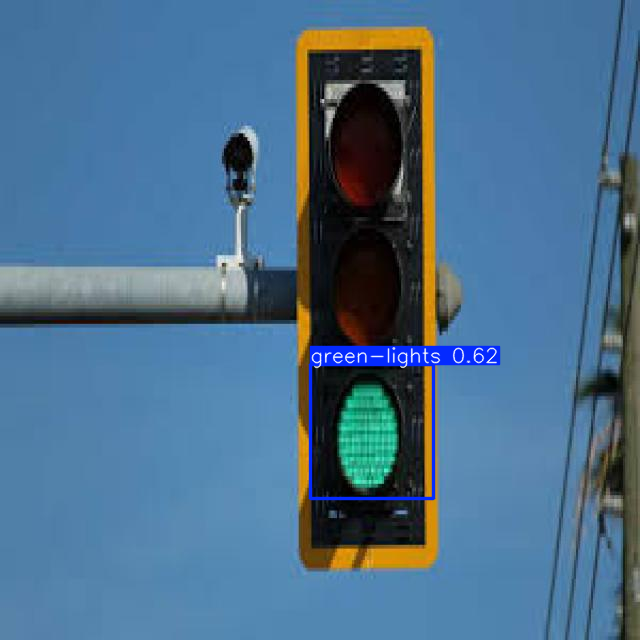

In [ ]:
# Perform object detection on an image
results = model("/content/drive/MyDrive/AutoDrive/data/datasets/TrafficLightDetection/test/images/images_jpeg.rf.f93f1d5e624f19c28d4ed1855fbbb545.jpg")
results[0].show()

## Lane Segmentation (Custom Dataset)

### Train on Large model

In [ ]:
# Load Model
model = YOLO("/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11l-seg.pt")

In [ ]:
# Fine-Tune Model
train_results = model.train(
    data="/content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    task="segment",
    device=0,
)

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11l-seg.pt, data=/content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

100%|██████████| 755k/755k [00:00<00:00, 28.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/labels... 1764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [14:55<00:00,  1.97it/s]

train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0000_jpg.rf.b5e6b4c28cb8d00ed023a3383f450d22.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0000_jpg.rf.ccad9fcde9d67f92b7259b954c9f4165.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0000_jpg.rf.f0962bac6b3b1777c20336a16a2405de.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0006_jpg.rf.65b193ac1f58b2a777590e55dc71362c.jpg: 1 duplicate lab

train: New cache created: /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

val: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/images/road_-_80400-720p-_mp4-0031_jpg.rf.3205a1a8c47677a810caa0fe2d85e49c.jpg: 1 duplicate labels removed
val: New cache created: /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.9G     0.9364      1.884      1.292      1.237         35        640: 100%|██████████| 111/111 [01:53<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        100        497     0.0169      0.229    0.00958    0.00554     0.0129      0.174     0.0059    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      12.4G      1.051      1.762      1.119      1.287         50        640: 100%|██████████| 111/111 [01:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        100        497      0.204      0.292      0.105     0.0516      0.123      0.169      0.042     0.0187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.4G      1.057      1.668      1.058      1.304         40        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all        100        497      0.598      0.539      0.494      0.301      0.561      0.523      0.468      0.224

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.4G     0.9951      1.603      1.009      1.262         16        640: 100%|██████████| 111/111 [01:46<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        100        497      0.692      0.696      0.664      0.445      0.645      0.648      0.574      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.4G     0.9129      1.459      0.919      1.211         30        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        100        497       0.73      0.802      0.768      0.612      0.717      0.814      0.749      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.4G     0.8783      1.428     0.8569      1.189         27        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        100        497       0.77      0.811      0.787      0.574      0.754      0.788       0.75      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.5G      0.825      1.328     0.8177      1.162         50        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all        100        497      0.695      0.831      0.742      0.567      0.687      0.809      0.715      0.458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.5G     0.8151      1.312     0.7993      1.161         38        640: 100%|██████████| 111/111 [01:46<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        100        497      0.743       0.75      0.765      0.589       0.73      0.737      0.738      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.5G     0.7821      1.265     0.7741      1.142         36        640: 100%|██████████| 111/111 [01:45<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        100        497      0.751      0.822      0.776      0.611      0.749      0.815      0.749      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.5G     0.7545      1.187     0.7291      1.118         34        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


                   all        100        497       0.77      0.766      0.769      0.602      0.761      0.757      0.743      0.524

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.6G     0.7227      1.173     0.7071      1.105         27        640: 100%|██████████| 111/111 [01:44<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        100        497      0.766       0.84      0.808       0.68      0.755      0.827      0.772      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.6G     0.7159      1.179     0.7157      1.101         31        640: 100%|██████████| 111/111 [01:44<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        100        497      0.727      0.841      0.796      0.669      0.714      0.828      0.767       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.6G     0.7053      1.123      0.691      1.099         49        640: 100%|██████████| 111/111 [01:46<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        100        497      0.801      0.813      0.796      0.657      0.788        0.8      0.773      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      12.6G     0.6888      1.106     0.6748      1.083         36        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        100        497       0.79      0.784      0.742      0.602      0.777      0.772      0.719      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      12.6G     0.6883       1.09      0.672      1.084         46        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


                   all        100        497      0.763      0.876      0.806      0.681      0.754      0.856      0.781      0.605

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      12.6G     0.6805      1.062     0.6541      1.075         17        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


                   all        100        497      0.762      0.875      0.797      0.665      0.746      0.857      0.782      0.584

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      12.6G     0.6627       1.09     0.6545      1.066         39        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        100        497      0.787      0.845      0.812      0.692      0.771       0.83      0.787        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      12.6G     0.6509      1.059     0.6436      1.064         37        640: 100%|██████████| 111/111 [01:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497      0.782      0.833      0.824      0.709      0.778      0.829       0.81      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      12.6G     0.6338      1.007      0.612      1.047         29        640: 100%|██████████| 111/111 [01:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497       0.77      0.833      0.813      0.693      0.759      0.822      0.784      0.595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.6G     0.6292      1.035     0.6114      1.048         32        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        100        497      0.789      0.862       0.83      0.718      0.779      0.852      0.811      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.6G     0.6197       1.02     0.6244      1.043         42        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        100        497      0.774      0.865      0.818       0.72      0.765      0.856      0.802      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.6G      0.614     0.9695      0.601      1.041         25        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497      0.778      0.795      0.794      0.673      0.767      0.785      0.779      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.6G     0.6056     0.9942     0.5899      1.033         19        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        100        497      0.844      0.819      0.852      0.738      0.835      0.811      0.837       0.65



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.6G     0.5926     0.9607     0.5848      1.026         48        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497      0.812      0.848      0.837      0.727      0.805      0.829      0.812      0.633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.6G     0.5889     0.9471     0.5693      1.024         29        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        100        497      0.803      0.838      0.839      0.735      0.787      0.823      0.816      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      12.6G     0.5863     0.9288     0.5758      1.026         23        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        100        497      0.821      0.832      0.839      0.735      0.811      0.822       0.82      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.6G     0.5719     0.9408     0.5678      1.021         41        640: 100%|██████████| 111/111 [01:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        100        497      0.791      0.836      0.819      0.686      0.787      0.833      0.807      0.615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      12.6G     0.5719     0.9366     0.5605      1.013         30        640: 100%|██████████| 111/111 [01:48<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        100        497      0.785      0.858      0.833      0.729      0.777      0.849       0.82       0.65



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.6G     0.5544     0.9051     0.5565      1.007         15        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        100        497       0.79      0.862      0.843      0.743      0.777      0.855      0.821      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      12.6G     0.5551     0.9247     0.5511      1.005         36        640: 100%|██████████| 111/111 [01:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497      0.798      0.856       0.85      0.745      0.786      0.844       0.83      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.6G     0.5433     0.8664     0.5295     0.9941         37        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        100        497      0.786      0.864      0.834      0.737      0.781      0.854      0.819      0.648



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      12.6G     0.5453      0.863     0.5383      1.002         15        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        100        497      0.777      0.891      0.832      0.734      0.763      0.876      0.811      0.645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.6G     0.5311     0.8576     0.5195     0.9925         47        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        100        497      0.791      0.899      0.841      0.735      0.782       0.89      0.827      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      12.6G     0.5259     0.8841      0.521     0.9897         19        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        100        497      0.774      0.861      0.822      0.726      0.762      0.849      0.804       0.64



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.6G     0.5157     0.8515      0.513     0.9837         21        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        100        497      0.809      0.878      0.837      0.738      0.803      0.872      0.822      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      12.6G     0.5158     0.8445     0.5106      0.988         23        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        100        497      0.833      0.848      0.847      0.752      0.821      0.837      0.829      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.6G     0.5066     0.8297     0.5061     0.9809         26        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        100        497      0.813      0.858       0.83      0.741        0.8      0.851      0.814      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      12.6G     0.5007     0.8655     0.5021     0.9783         53        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        100        497      0.832       0.84      0.835      0.746      0.828      0.837      0.827      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.6G     0.4975      0.806     0.4893     0.9724         34        640: 100%|██████████| 111/111 [01:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        100        497      0.847      0.831       0.84      0.742      0.839      0.824      0.822      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.6G     0.4886     0.8187     0.4829     0.9721         36        640: 100%|██████████| 111/111 [01:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497      0.818      0.863      0.844       0.75      0.808      0.853      0.827      0.664


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.6G     0.4627     0.6814      0.431      1.001         18        640: 100%|██████████| 111/111 [01:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        100        497      0.817      0.873      0.847      0.755      0.814      0.872      0.836      0.674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.6G     0.4537     0.6676     0.4183     0.9975         15        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        100        497      0.843      0.847       0.85       0.76      0.792      0.897       0.84      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.6G     0.4381     0.6487     0.4131      0.985         16        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        100        497      0.822      0.865      0.841      0.751      0.811      0.854      0.822      0.661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.6G     0.4252     0.6298     0.3993     0.9751         16        640: 100%|██████████| 111/111 [01:44<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        100        497      0.833      0.865      0.858      0.771      0.827      0.839      0.842      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.6G     0.4247     0.6244     0.3992     0.9738         19        640: 100%|██████████| 111/111 [01:45<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        100        497       0.82      0.876      0.842      0.759      0.814      0.873      0.827      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.6G     0.4114     0.6162     0.3875     0.9647         14        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        100        497      0.833      0.843      0.854      0.768      0.798      0.856      0.837      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.6G     0.4055     0.6098     0.3842     0.9684         14        640: 100%|██████████| 111/111 [01:45<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        100        497      0.832      0.857      0.853      0.764      0.822      0.844      0.834      0.682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.6G     0.4029     0.6142     0.3782     0.9618         16        640: 100%|██████████| 111/111 [01:44<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        100        497      0.839      0.857      0.853      0.768      0.823      0.847      0.834      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.6G     0.3868     0.5887     0.3699       0.95         14        640: 100%|██████████| 111/111 [01:44<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        100        497       0.84      0.858      0.851      0.765      0.829      0.848      0.835       0.68



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.6G     0.3835     0.5853     0.3679     0.9511         16        640: 100%|██████████| 111/111 [01:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        100        497      0.837      0.855      0.852      0.767      0.827      0.843      0.833      0.682



50 epochs completed in 1.550 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 55.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 55.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l-seg summary (fused): 203 layers, 27,586,134 parameters, 0 gradients, 141.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:00<00:02,  1.16it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


                   all        100        497      0.832      0.864      0.858      0.772      0.827      0.839      0.842      0.687
                  lane         70        333       0.73      0.844      0.753      0.641       0.74      0.832      0.746      0.504
                  road         98        164      0.935      0.884      0.963      0.902      0.914      0.846      0.938       0.87
Speed: 0.3ms preprocess, 22.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/segment/train


In [ ]:
# Evaluate model performance on the validation set
model = YOLO("/content/drive/MyDrive/AutoDrive/trained-models/yolo_large_lane.pt")
metrics = model.val()

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l-seg summary (fused): 203 layers, 27,586,134 parameters, 0 gradients, 141.9 GFLOPs


val: Scanning /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/images/road_-_80400-720p-_mp4-0031_jpg.rf.3205a1a8c47677a810caa0fe2d85e49c.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:02<00:06,  1.39s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


                   all        100        497      0.833      0.864      0.858      0.772      0.824      0.835       0.84      0.683
                  lane         70        333      0.731      0.844      0.753      0.642      0.735      0.826      0.742      0.497
                  road         98        164      0.934      0.884      0.963      0.902      0.914      0.844      0.938      0.869
Speed: 3.7ms preprocess, 42.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/val



image 1/1 /content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/test/images/drive_-_1686-720p-_mp4-0008_jpg.rf.af362e7776623942392bc6e482c9ccbc.jpg: 640x640 4 lanes, 1 road, 60.9ms
Speed: 2.8ms preprocess, 60.9ms inference, 21.2ms postprocess per image at shape (1, 3, 640, 640)


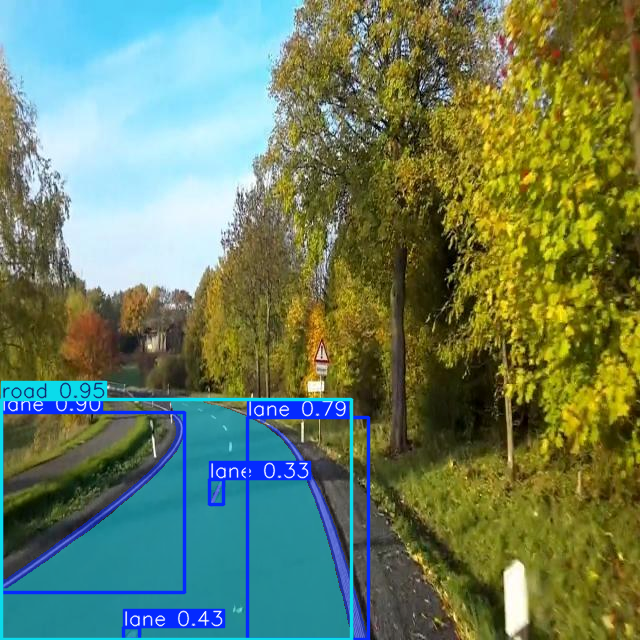

In [ ]:
# Perform object detection on an image
results = model("/content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/test/images/drive_-_1686-720p-_mp4-0008_jpg.rf.af362e7776623942392bc6e482c9ccbc.jpg")
results[0].show()

### Train on Nano model

In [ ]:
# Load Model
model = YOLO("/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11n-seg.pt")

In [ ]:
# Fine-Tune Model
train_results = model.train(
    data="/content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/data.yaml",
    epochs=100,
    imgsz=640,
    batch=64,
    task="segment",
    device=0,
)

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=/content/drive/MyDrive/AutoDrive/yolo-weights/yolo11n-seg.pt, data=/content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/data.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

train: Scanning /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/labels.cache... 1764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0000_jpg.rf.b5e6b4c28cb8d00ed023a3383f450d22.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0000_jpg.rf.ccad9fcde9d67f92b7259b954c9f4165.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0000_jpg.rf.f0962bac6b3b1777c20336a16a2405de.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/train/images/pexels-zero-13718687-540p-_mp4-0006_jpg.rf.65b193ac1f58b2a777590e55dc71362c.jpg: 1 duplicate lab


val: Scanning /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/images/road_-_80400-720p-_mp4-0031_jpg.rf.3205a1a8c47677a810caa0fe2d85e49c.jpg: 1 duplicate labels removed


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.5G     0.9913      2.631      2.573      1.249        250        640: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all        100        497     0.0107      0.733      0.466        0.3    0.00903      0.549      0.286      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.5G     0.8554      1.429      1.279      1.111        264        640: 100%|██████████| 28/28 [00:49<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

                   all        100        497      0.655      0.172      0.454        0.3      0.569      0.169      0.397      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.5G     0.8939      1.411      1.146      1.122        262        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all        100        497      0.312      0.219      0.195     0.0928      0.237      0.173      0.117     0.0461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.5G     0.9123      1.424      1.088      1.137        273        640: 100%|██████████| 28/28 [00:59<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

                   all        100        497       0.43      0.525      0.393       0.23      0.405      0.532      0.367      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.5G     0.8713       1.39     0.9873      1.114        294        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


                   all        100        497      0.418       0.48      0.376      0.215      0.298      0.334      0.217      0.089

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.5G     0.8343      1.298     0.9007      1.093        284        640: 100%|██████████| 28/28 [00:52<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]

                   all        100        497      0.517      0.656      0.557      0.375      0.488      0.599      0.491      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.5G     0.8215      1.251     0.8631      1.085        294        640: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

                   all        100        497      0.587      0.707      0.615      0.445      0.546      0.658      0.537      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.5G     0.8066      1.213     0.8347      1.086        221        640: 100%|██████████| 28/28 [00:50<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

                   all        100        497      0.749      0.785      0.786      0.603      0.725      0.746       0.71      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.5G     0.7799      1.159     0.8102      1.065        312        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]

                   all        100        497      0.661      0.768      0.748      0.575      0.662      0.677      0.689      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.5G     0.7417      1.143     0.7642      1.051        272        640: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

                   all        100        497      0.698      0.778      0.716      0.509      0.659      0.751      0.664      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.5G     0.7355      1.088     0.7455      1.044        270        640: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

                   all        100        497      0.625      0.793      0.714      0.527      0.613      0.775      0.694      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.5G     0.7284      1.108     0.7414      1.042        266        640: 100%|██████████| 28/28 [00:49<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]

                   all        100        497      0.711      0.735      0.728      0.553        0.7      0.724      0.709      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.5G     0.7241      1.117     0.7343      1.044        292        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

                   all        100        497      0.772      0.828      0.778      0.633      0.747      0.802      0.731      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.5G     0.6979      1.066     0.7111      1.027        286        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

                   all        100        497      0.728      0.861      0.811      0.647      0.708      0.839      0.779      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.5G     0.7141      1.092     0.7166      1.041        241        640: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

                   all        100        497      0.812       0.81      0.806      0.675      0.803      0.801       0.79       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.5G     0.6876      1.053     0.7085      1.024        234        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

                   all        100        497      0.764      0.836      0.792      0.675      0.744      0.817      0.762      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.5G     0.6705      1.018     0.6747      1.013        274        640: 100%|██████████| 28/28 [00:54<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

                   all        100        497      0.758      0.844      0.798      0.653      0.746      0.831      0.775      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.5G     0.6759      1.026     0.6829      1.019        296        640: 100%|██████████| 28/28 [00:53<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all        100        497      0.764       0.85      0.809      0.672      0.755      0.836      0.789       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.5G     0.6607      1.012     0.6607      1.009        336        640: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]

                   all        100        497      0.813      0.854       0.84       0.71      0.806      0.841       0.81      0.611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.5G     0.6616      1.012     0.6616      1.014        285        640: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]

                   all        100        497      0.781      0.872      0.823      0.673      0.768      0.858       0.79      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.5G     0.6555     0.9923     0.6564      1.007        296        640: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

                   all        100        497      0.817      0.837      0.837      0.702      0.804      0.829      0.819      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.5G     0.6357     0.9663     0.6519     0.9995        295        640: 100%|██████████| 28/28 [00:54<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

                   all        100        497      0.782      0.826      0.808       0.66      0.767      0.811      0.789      0.598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.5G     0.6437     0.9815     0.6421      1.001        321        640: 100%|██████████| 28/28 [00:53<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all        100        497       0.76      0.867       0.82      0.695       0.75      0.854      0.798       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.5G     0.6289     0.9708     0.6357      1.001        256        640: 100%|██████████| 28/28 [00:53<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

                   all        100        497      0.709      0.882       0.82      0.674      0.692      0.863      0.792      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.5G     0.6182     0.9452     0.6208     0.9874        242        640: 100%|██████████| 28/28 [00:53<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

                   all        100        497      0.744      0.874      0.818      0.701       0.74      0.869      0.803       0.63



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.5G     0.6344     0.9577     0.6399     0.9988        319        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all        100        497      0.829      0.846      0.852      0.696      0.816      0.836       0.83      0.611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.5G      0.614     0.9492     0.6122     0.9898        282        640: 100%|██████████| 28/28 [00:54<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all        100        497      0.829      0.845      0.832      0.713      0.842      0.819      0.814      0.645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.5G     0.6102     0.9248     0.6133     0.9864        326        640: 100%|██████████| 28/28 [00:56<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all        100        497      0.779      0.861      0.816      0.682      0.764      0.846      0.784      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.5G     0.5986     0.9285     0.6059     0.9806        254        640: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]

                   all        100        497       0.83      0.794      0.803      0.695      0.822      0.786      0.791      0.607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.5G     0.6051     0.9294     0.6064     0.9864        272        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all        100        497      0.752      0.837      0.803      0.692      0.751      0.805      0.784      0.617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.5G     0.5934     0.9055     0.5924     0.9758        324        640: 100%|██████████| 28/28 [00:53<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

                   all        100        497      0.787        0.8      0.816      0.685      0.783      0.796      0.802      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.5G     0.5965     0.9072     0.5937     0.9825        252        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all        100        497      0.777      0.866      0.818      0.705      0.791      0.844      0.808      0.635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.5G     0.5853      0.895     0.5841     0.9719        290        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all        100        497      0.782      0.844      0.829      0.727      0.774      0.837      0.815       0.63



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.5G     0.5844     0.8699     0.5826     0.9733        277        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]

                   all        100        497      0.775      0.831      0.814      0.701      0.752      0.805      0.781      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.5G     0.5797     0.8808     0.5813     0.9726        297        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

                   all        100        497      0.818      0.841      0.841      0.737      0.806      0.831      0.825      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.5G     0.5762     0.8836     0.5756     0.9685        310        640: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all        100        497      0.833      0.845       0.85      0.738      0.824      0.835      0.838      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.5G     0.5706     0.8853     0.5726     0.9749        329        640: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]

                   all        100        497      0.778      0.841      0.847      0.728      0.769      0.832      0.827      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.5G     0.5582     0.8959      0.569     0.9624        267        640: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]

                   all        100        497      0.808      0.858      0.846      0.746      0.806      0.842      0.832      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.5G     0.5732     0.8496     0.5651     0.9651        352        640: 100%|██████████| 28/28 [00:53<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

                   all        100        497      0.829      0.824      0.838      0.736      0.823       0.82      0.818      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.5G     0.5576     0.8486     0.5692     0.9609        273        640: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

                   all        100        497      0.816      0.884       0.85      0.743      0.807      0.867      0.832       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.5G     0.5646     0.8377     0.5625     0.9653        222        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]

                   all        100        497      0.804      0.864      0.852      0.752      0.813      0.841      0.838      0.667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.5G      0.559      0.815     0.5513     0.9636        266        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

                   all        100        497      0.823      0.864      0.852       0.75      0.808      0.849      0.832      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.5G     0.5403     0.8391     0.5406     0.9533        296        640: 100%|██████████| 28/28 [00:51<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all        100        497      0.818      0.857      0.847      0.733      0.809      0.841      0.825      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.5G     0.5499     0.8213     0.5508     0.9604        233        640: 100%|██████████| 28/28 [00:52<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all        100        497      0.849      0.863      0.858      0.757      0.842      0.856      0.843      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.5G     0.5526     0.8177     0.5483     0.9556        268        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

                   all        100        497      0.767      0.863      0.819      0.714      0.759      0.861      0.806      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.5G     0.5406     0.8488      0.543      0.955        259        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

                   all        100        497      0.819      0.851      0.848      0.731      0.808       0.84      0.833       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.5G     0.5383     0.8259     0.5463     0.9538        273        640: 100%|██████████| 28/28 [00:52<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all        100        497       0.83      0.857      0.841      0.736      0.828      0.848      0.823      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.5G     0.5353     0.8338     0.5379     0.9537        283        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]

                   all        100        497      0.804      0.884      0.852      0.747      0.784       0.89      0.837      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.5G     0.5402     0.8016     0.5376     0.9506        286        640: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]

                   all        100        497       0.82      0.869      0.854       0.75      0.808      0.851      0.834      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.5G     0.5255     0.8325     0.5265     0.9461        304        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

                   all        100        497      0.807      0.858      0.835      0.729      0.803      0.855      0.817      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.5G     0.5247     0.7964     0.5232      0.949        237        640: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

                   all        100        497      0.802      0.855      0.836      0.729      0.796      0.849      0.817      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.5G     0.5237     0.8138     0.5188     0.9422        261        640: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

                   all        100        497      0.799      0.879      0.835      0.744      0.795      0.876      0.825      0.672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.5G     0.5143     0.7969     0.5133     0.9428        282        640: 100%|██████████| 28/28 [00:51<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]

                   all        100        497      0.838      0.863      0.851      0.752      0.845      0.839      0.839      0.672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.5G     0.5128     0.7971     0.5169     0.9441        284        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]

                   all        100        497       0.83       0.85      0.843      0.742      0.821      0.849       0.83      0.675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.5G     0.5123     0.7795     0.5079     0.9416        296        640: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]

                   all        100        497      0.823      0.859      0.849      0.736      0.825      0.842      0.835      0.667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.5G     0.5166     0.8039     0.5154     0.9495        270        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]

                   all        100        497      0.834      0.841      0.841      0.739      0.829      0.838      0.823      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.5G     0.5108       0.77      0.504     0.9402        294        640: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]

                   all        100        497      0.811      0.877       0.86      0.756       0.84       0.83      0.848      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.5G     0.5098     0.7777     0.5171     0.9404        233        640: 100%|██████████| 28/28 [00:56<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

                   all        100        497      0.844      0.848      0.861      0.757      0.838      0.843      0.843      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.5G     0.5055     0.7813     0.5016     0.9391        294        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

                   all        100        497      0.812      0.883      0.854      0.755      0.803      0.873      0.839      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.5G     0.5085     0.7749     0.5094      0.939        265        640: 100%|██████████| 28/28 [00:54<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all        100        497      0.816      0.885      0.858      0.751      0.807      0.876      0.836      0.675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.5G        0.5     0.7813     0.4987     0.9351        297        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

                   all        100        497      0.807      0.871      0.858      0.764      0.795      0.858      0.835      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.5G     0.5025     0.7485     0.4961     0.9381        248        640: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all        100        497      0.813       0.88      0.852      0.756      0.802       0.87      0.831      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.5G     0.5074      0.759     0.5041     0.9423        264        640: 100%|██████████| 28/28 [00:53<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


                   all        100        497      0.814       0.88      0.837      0.742      0.805       0.87      0.826      0.666

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.5G     0.4921     0.7779     0.4876     0.9303        278        640: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

                   all        100        497      0.794      0.899      0.855      0.763       0.79      0.894      0.838       0.68



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.5G     0.4985     0.7438     0.4954     0.9362        260        640: 100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]

                   all        100        497      0.829      0.848      0.852      0.758      0.811      0.875       0.84       0.68



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.5G      0.487     0.7609     0.4815     0.9308        270        640: 100%|██████████| 28/28 [00:50<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

                   all        100        497      0.813       0.86      0.847      0.757      0.811      0.852      0.831      0.685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.5G     0.4874     0.7545     0.4863     0.9306        297        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all        100        497      0.821      0.869      0.855      0.762      0.813      0.852      0.835      0.673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.5G     0.4843     0.7388     0.4812      0.931        249        640: 100%|██████████| 28/28 [00:49<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

                   all        100        497      0.835      0.854      0.854      0.764      0.788      0.897      0.845      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.5G     0.4908      0.744     0.4873      0.931        258        640: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

                   all        100        497      0.815       0.89      0.852      0.754      0.807      0.881      0.834      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.5G     0.4816     0.7429     0.4742     0.9262        284        640: 100%|██████████| 28/28 [00:51<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]

                   all        100        497      0.831      0.873      0.854      0.761       0.83      0.872      0.842      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.5G     0.4801     0.7699     0.4762      0.929        305        640: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

                   all        100        497      0.811      0.886      0.861      0.772       0.81      0.884      0.856      0.689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.5G     0.4818     0.7367     0.4724     0.9242        304        640: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

                   all        100        497      0.828      0.891      0.865      0.771      0.823      0.894      0.857      0.695



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.5G     0.4671     0.7188     0.4683     0.9212        281        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all        100        497      0.827      0.862      0.847      0.762      0.816      0.851      0.828      0.675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.5G      0.462     0.7211      0.467     0.9194        245        640: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

                   all        100        497      0.825      0.882      0.845      0.755      0.821      0.878      0.832      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.5G     0.4602     0.7086     0.4557     0.9222        280        640: 100%|██████████| 28/28 [00:54<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

                   all        100        497      0.799      0.897      0.853      0.768      0.789      0.886      0.837      0.686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.5G     0.4688      0.728     0.4602      0.922        255        640: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all        100        497      0.821      0.896      0.852      0.761      0.814      0.884      0.839      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.5G     0.4656       0.72     0.4644     0.9204        261        640: 100%|██████████| 28/28 [00:49<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

                   all        100        497      0.804      0.898      0.848       0.76        0.8      0.893      0.838      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.5G      0.461     0.7015     0.4595     0.9157        261        640: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

                   all        100        497      0.803       0.89      0.855      0.769       0.81      0.884      0.841      0.683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.5G     0.4521     0.6884      0.448     0.9165        296        640: 100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

                   all        100        497       0.83      0.887      0.857      0.766      0.827      0.881      0.846      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.5G     0.4667     0.7351     0.4611     0.9236        260        640: 100%|██████████| 28/28 [00:52<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                   all        100        497      0.834      0.869      0.845      0.758      0.825      0.857       0.83      0.674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.5G     0.4521     0.7063     0.4537     0.9144        253        640: 100%|██████████| 28/28 [00:49<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all        100        497      0.824      0.878      0.858      0.774      0.822      0.877      0.847      0.688



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.5G     0.4566     0.7034     0.4507     0.9173        327        640: 100%|██████████| 28/28 [00:52<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all        100        497      0.803      0.903      0.858      0.764      0.797      0.896      0.843      0.685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.5G     0.4586     0.6872     0.4494      0.918        280        640: 100%|██████████| 28/28 [00:51<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all        100        497      0.822      0.891      0.854      0.767      0.806      0.899      0.845      0.691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.5G     0.4447     0.6917     0.4486     0.9138        279        640: 100%|██████████| 28/28 [00:51<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all        100        497      0.846      0.876      0.849      0.763      0.843      0.873       0.84      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.5G     0.4466      0.698     0.4384     0.9147        282        640: 100%|██████████| 28/28 [00:53<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

                   all        100        497      0.835      0.879      0.858      0.774      0.828      0.872      0.845      0.691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.5G     0.4386     0.6761     0.4391     0.9128        276        640: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

                   all        100        497      0.836      0.881      0.854      0.767      0.834      0.879      0.845      0.689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.5G     0.4363     0.6835     0.4416     0.9129        342        640: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

                   all        100        497      0.831      0.872      0.861      0.775      0.825      0.866      0.847      0.691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.5G     0.4435     0.6745     0.4439     0.9151        271        640: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]

                   all        100        497      0.815      0.906      0.857      0.767      0.822      0.878      0.844       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.5G     0.4334     0.6876     0.4355     0.9099        254        640: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

                   all        100        497      0.817       0.89      0.858      0.771      0.803      0.903      0.849      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.5G     0.4434     0.6986     0.4397     0.9112        300        640: 100%|██████████| 28/28 [00:52<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

                   all        100        497       0.82      0.889      0.857      0.771      0.811      0.879      0.843      0.689


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.5G      0.401      0.576     0.3928     0.9082        187        640: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]

                   all        100        497      0.821      0.897      0.858      0.768      0.824      0.882      0.847      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.5G     0.3861     0.5523     0.3702     0.8989        146        640: 100%|██████████| 28/28 [00:43<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all        100        497      0.831      0.876      0.857      0.774      0.828      0.873      0.845       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.5G     0.3848     0.5608     0.3717     0.8996        153        640: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all        100        497       0.83      0.876      0.863      0.779      0.826      0.869       0.85       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.5G       0.38     0.5543     0.3648     0.8984        148        640: 100%|██████████| 28/28 [00:43<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all        100        497      0.811      0.884      0.861      0.778      0.817      0.864      0.848      0.693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.5G     0.3728     0.5561     0.3622      0.893        169        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

                   all        100        497      0.838      0.859      0.866      0.782      0.836      0.858      0.852      0.695



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.5G     0.3703     0.5394     0.3569     0.8943        160        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all        100        497      0.829      0.889      0.867      0.786      0.828      0.885      0.854      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.5G     0.3694     0.5484     0.3553     0.8922        160        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

                   all        100        497      0.807      0.905      0.866      0.783      0.804      0.895       0.85      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.5G     0.3666     0.5326     0.3556     0.8957        162        640: 100%|██████████| 28/28 [00:44<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

                   all        100        497       0.82      0.898      0.866      0.783       0.81      0.898      0.852      0.691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.5G      0.366     0.5316     0.3538     0.8962        152        640: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

                   all        100        497      0.824      0.883      0.867      0.785      0.807      0.891      0.852      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.5G     0.3622     0.5361     0.3485     0.8938        133        640: 100%|██████████| 28/28 [00:43<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

                   all        100        497      0.821      0.885      0.867      0.784       0.82      0.878      0.853      0.699



100 epochs completed in 1.561 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


                   all        100        497      0.829      0.889      0.868      0.786      0.828      0.885      0.855      0.698
                  lane         70        333       0.74      0.857      0.775      0.663      0.743      0.856      0.768      0.532
                  road         98        164      0.918      0.921       0.96       0.91      0.913      0.915      0.941      0.863
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train


In [ ]:
# Evaluate model performance on the validation set
model = YOLO("/content/drive/MyDrive/AutoDrive/trained-models/yolo_nano_lane.pt")
metrics = model.val()

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs


val: Scanning /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1y3Fitc2PBSsiszALgmFpd1M90AnYxFWH/AutoDrive/data/datasets/LaneSegmentation/valid/images/road_-_80400-720p-_mp4-0031_jpg.rf.3205a1a8c47677a810caa0fe2d85e49c.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


                   all        100        497      0.829      0.889      0.868      0.787      0.832      0.877      0.853      0.694
                  lane         70        333       0.74      0.856      0.776      0.665      0.751      0.851      0.764      0.525
                  road         98        164      0.918      0.921       0.96       0.91      0.914      0.904      0.941      0.863
Speed: 8.3ms preprocess, 44.8ms inference, 0.0ms loss, 15.1ms postprocess per image
Results saved to runs/segment/val



image 1/1 /content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/test/images/drive_-_1686-720p-_mp4-0008_jpg.rf.af362e7776623942392bc6e482c9ccbc.jpg: 640x640 4 lanes, 1 road, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


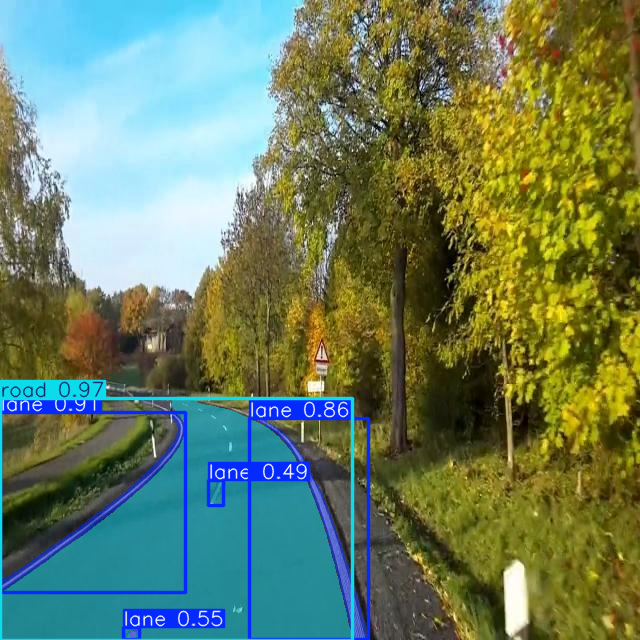

In [ ]:
# Perform object detection on an image
results = model("/content/drive/MyDrive/AutoDrive/data/datasets/LaneSegmentation/test/images/drive_-_1686-720p-_mp4-0008_jpg.rf.af362e7776623942392bc6e482c9ccbc.jpg")
results[0].show()